In [1]:

from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

In [ ]:
def wrangle(filepath):
    
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    #Drop high null value column
    df.drop(columns = ['floor' , 'expenses'], inplace = True)
    
    #High and low cardinality
    df.drop(columns = ['operation' , 'property_type' , 'currency' , 'properati_url'], inplace = True)
    
    #Drop Leakage
    df.drop(columns = ['price','price_aprox_local_currency','price_per_m2', 'price_usd_per_m2'], inplace = True)
    
    #Drop column with multicollinearity
    df.drop(columns = ['surface_total_in_m2', 'rooms'], inplace = True)
    

    
    return df

In [10]:
#Bringing in more files
files = glob(R"C:\Users\HP\Desktop\buenos-aires-real-estate-*.csv")

In [14]:
files

['C:\\Users\\HP\\Desktop\\buenos-aires-real-estate-1.csv',
 'C:\\Users\\HP\\Desktop\\buenos-aires-real-estate-2.csv']

In [16]:
df = [wrangle(file) for file in files]

In [17]:
df = pd.concat(df, ignore_index = True)

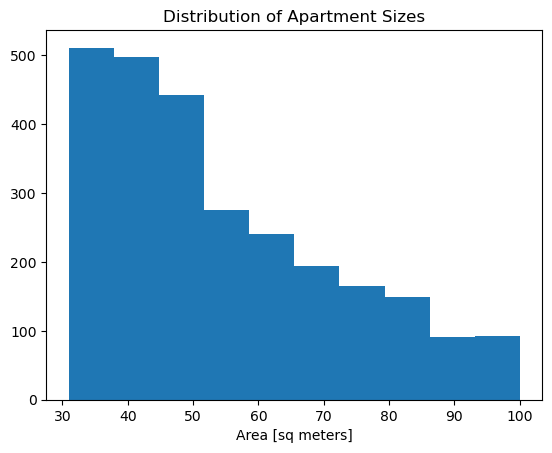

In [18]:
plt.hist(df["surface_covered_in_m2"])
plt.xlabel("Area [sq meters]")
plt.title("Distribution of Apartment Sizes");

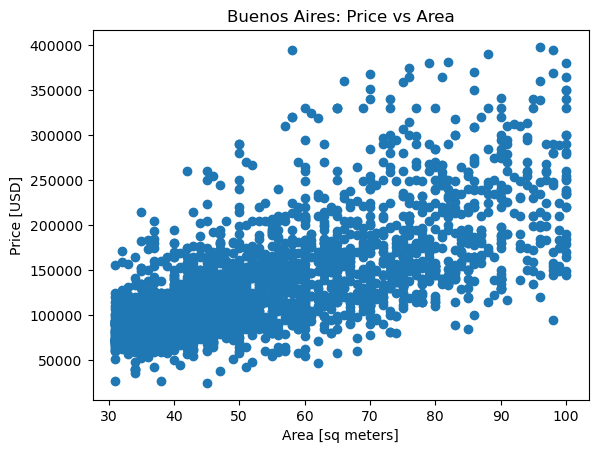

In [19]:
plt.scatter(x= df["surface_covered_in_m2"], y = df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title('Buenos Aires: Price vs Area')

plt.show()

In [20]:
#spilting

X_train = df[['surface_covered_in_m2' ,'lat', 'lon','neighborhood']]

y_train = df["price_aprox_usd"]


In [21]:
#Baseline prediction
y_pred_baseline =[y_train.mean()]* len(y_train)
y_pred_baseline[ :5]

[134732.97340481562,
 134732.97340481562,
 134732.97340481562,
 134732.97340481562,
 134732.97340481562]

In [22]:
print("Mean apt price:", round(y_train.mean(), 2))

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 134732.97
Baseline MAE: 45422.75166805662


In [23]:
#Building model

model = make_pipeline( 
    OneHotEncoder(use_cat_names = True), SimpleImputer(), Ridge()
)


model.fit(X_train, y_train)


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [24]:
X_train.head()

,surface_covered_in_m2,lat,lon,neighborhood
0,70.0,-34.584651,-58.454693,Chacarita
1,42.0,-34.638979,-58.500115,Villa Luro
2,54.0,-34.615847,-58.459957,Caballito
3,42.0,-34.625222,-58.382382,Constitución
4,50.0,-34.610610,-58.412511,Once


In [25]:
#Training
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error( y_train, y_pred_training))

Training MAE: 24638.873983456142


In [26]:
def make_prediction(area, lat, lon, neighborhood):
    data= {"surface_covered_in_m2" : area,
           'lat' : lat,
           'lon' : lon,
           'neighborhood' : neighborhood}
    df = pd.DataFrame(data, index =[0])
    
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"
   

In [27]:
make_prediction(32, -22.60, -45.46, "flores")

'Predicted apartment price: $1411641.64'